# Guide to Extracting Data w/ APIs from the Withings ScanWatch

<img src="https://imgur.com/3Z2W8HK.png" width="500"/>

Ever wanted a smart watch with an EKG? Introducing the [Withings ScanWatch](https://www.withings.com/us/en/scanwatch), a smart watch that can not only detect your heart rate optically, but also with an EKG! While this notebook is meant for the ScanWatch, it can be easily adapted to any other Withings product with some modifications.

Also note that you need to set up your Withings ScanWatch prior to running this notebook.

If you want to know more about Withings Body+ Scale, see the [README](https://github.com/alrojo/wearipedia/tree/main/wearables/withings-scanwatch) for a detailed analysis of performances, sensors, data privacy, and extraction pipelines.

We will be able to extract the following parameters (see the definitions at [this documenation page](https://developer.withings.com/api-reference#operation/sleepv2-getsummary)):

<details>

<summary> <strong> <font size=3> Click here to view all extractable parameters </font> </strong> </summary>

| Parameter Name        | Sampling Frequency |
|-----------------------|--------------------|
| Heart Rate            | Every 10 minutes OR every second (when set to [continuous heart rate mode](https://support.withings.com/hc/en-us/articles/360010042798-ScanWatch-Tracking-my-heart-rate))  |
| # of REM sleep phases | Per sleep          |
| Sleep Efficiency      | Per sleep          |
| Sleep Latency         | Per sleep          |
| Total Sleep Time      | Per sleep          |
| Total Time in bed     | Per sleep          |
| Wakeup latency        | Per sleep          |
| Waso                  | Per sleep          |
| Asleepduration        | Per sleep          |
| Deep sleep duration   | Per sleep          |
| Duration to sleep     | Per sleep          |
| Duration to wakeup    | Per sleep          |
| Average heart rate    | Per sleep          |
| Max heart rate        | Per sleep          |
| Min heart rate        | Per sleep          |
| Light sleep duration  | Per sleep          |
| Night events          | Per sleep          |
| Out of bed count      | Per sleep          |
| REM sleep duration    | Per sleep          |
| Average resp rate    | Per sleep          |
| Minimal resp. rate    | Per sleep          |
| Max resp. rate        | Per sleep          |
| Sleep score           | Per sleep          |
| Total snoring time    | Per sleep          |
| Snoring episode count | Per sleep          |
| Wakeup count          | Per sleep          |
| Wakeup duration       | Per sleep          |


</details>

Note that Withings provides even more measurements than just these. You can check these out at the [API reference](https://developer.withings.com/api-reference/). Since we focus on heart rate and sleep here, though, those are the main measurement types we extract.

<br><br>
In this guide, we sequentially cover the following **five** topics to extract from the Withings API:
1. **Setup**
    - We cover setting up the watch and library imports in this section.
2. **Authentication/Authorization**
    - This requires a couple extra steps on your part
3. **Data extraction**
    - You can get data from the API in a couple lines of code.
4. **Data visualization**
    - 4.1: We reproduce a plot for heart rate over the course of a day
    - 4.2: We reproduce a plot for sleep data over the course of a week
    - 4.3: We visualize the times / days when the user fails to wear the watch.
5. **Data analysis**
    - 5.1: We try to find a correlation between the length of a sleep period and the median heart rate for that sleep period. We find that the correlation is not statistically significant.
    - 5.2: We demonstrate a simple outlier detection algorithm running on the dataset.

Disclaimer: this notebook is purely for educational purposes. All of the data currently stored in this notebook is purely *synthetic*, meaning randomly generated according to rules we created. Despite this, the end-to-end data extraction pipeline has been tested on our own data, meaning that if you enter your own credentials on your own Colab instance, you can visualize your own *real* data. That being said, we were unable to thoroughly test the timezone functionality, though, since we only have one account, so beware.

# 1. Setup

## 1.1 Study participant setup and usage

To set up the watch itself so that you can run this notebook, download the Health Mate app and follow the instructions on the app. The app will pair via bluetooth to the watch. In our experience, this process was fairly straightforward.

# 2. Authentication/Authorization

To be able to make requests to the API, the easiest way is to use the public developer API. This section roughly follows the steps outlined [here](https://developer.dexcom.com/authentication) on their website.

First, follow the non-colab steps listed below:

1. Visit the [developer portal](https://developer.withings.com/) and click "Open Developer Dashboard" on the top right.
2. Once logged in, click "Add an app".
3. For now, you can just click "I don't know" under "Services", accept terms of use, and click "Next".
5. Put whatever you want under "Application Name" (we used `withings-test`), anything under "Application Description", and "https://wbsapi.withings.net/v2/oauth2" under Registered URLs, then click "Done".
    - NOTE: "registered URLs" is intended to be a URL to a webserver you control and can receive requests from. However, in this notebook we are simply using it as a placeholder, as this functionality is not strictly necessary for obtaining your data.

In the end, you should see something like the below.

<img src="https://i.imgur.com/ttWojjU.png"></img>

Now we can proceed with the rest of the notebook.

To be able to make requests to the API and extract the data we need, we need to first issue an access token. This (ephemeral) access token will serve as our key to the data. While, you don't necessarily need to be familiar with how the issuing of the authtoken occurs, you can learn more about it by visiting [the official Withings tutorial](https://developer.withings.com/developer-guide/v3/integration-guide/public-health-data-api/get-access/oauth-web-flow/).

In [ ]:
#@title 6. Enter your credentials below (from the application you just created)

# we hide a bunch of the library imports in here :)
!pip install -q july

import requests
import urllib
import json
from datetime import datetime
from tqdm import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.ndimage import gaussian_filter
from scipy import stats
import july
from july.utils import date_range

CLIENT_ID = "" #@param {type:"string"}
CUSTOMER_SECRET = "" #@param {type:"string"}

STATE = 'string'
ACCOUNT_URL = 'https://account.withings.com'
CALLBACK_URI = 'https://wbsapi.withings.net/v2/oauth2'


payload = {'response_type': 'code',  # imposed string by the api
    'client_id': CLIENT_ID,
    'state': STATE,
    'scope': 'user.info,user.metrics,user.activity',  # see docs (https://developer.withings.com/api-reference/#operation/oauth2-authorize) for enhanced scope
    'redirect_uri': CALLBACK_URI,  # URL of this app
    #'mode': 'demo'  # Use demo mode, DELETE THIS FOR REAL APP
}

url = f'{ACCOUNT_URL}/oauth2_user/authorize2?'

for key, value in payload.items():
    url += f'{key}={value}&'

url = url[:-1]

print(url)

https://account.withings.com/oauth2_user/authorize2?response_type=code&client_id=&state=string&scope=user.info,user.metrics,user.activity&redirect_uri=https://wbsapi.withings.net/v2/oauth2


7. Now visit the above URL and click "Allow this app", and copy the URL you were redirected to into the text field below. Note that if you mess up once, you have to go through the above URL again (including clicking "Allow this app"). Also, the URL is only valid for 30 seconds, so be quick!

In [ ]:
#@title 7. Copy and paste the URL you were redirected to below
redirect_url = "https://wbsapi.withings.net/v2/oauth2?code=09f095bcd678c7beaa9285e189c5a3917329ed7d&state=string" #@param {type:"string"}

try:
    code = urllib.parse.parse_qs(urllib.parse.urlparse(redirect_url).query)['code'][0]
except Exception as e:
    print(f'Caught error:\n{e}\n')
    print("Please copy and paste the entire URL (including https)")

params = {
    'action': 'requesttoken',
    'grant_type': 'authorization_code',
    'client_id': CLIENT_ID,
    'client_secret': CUSTOMER_SECRET,
    'code': code,
    #'scope': 'user.info',
    'redirect_uri': 'https://wbsapi.withings.net/v2/oauth2'
}

out = requests.get('https://wbsapi.withings.net/v2/oauth2', data=params)

out = json.loads(out.text)

try:
    access_token = out['body']['access_token']
except KeyError as e:
    print('Took too long to paste in redirect URL. Please repeat step 7.')

Took too long to paste in redirect URL. Please repeat step 7.


Now that we have our access token, we can begin making requests to the API! This access token will last only three hours, though, so you would need to re-do step 7 if three hours pass.

# 3. Data extraction

Here, data extraction is pretty simple! We've made it possible to get all heart rate and sleep data in one function call each.

If you need to customize this part further and need to dig into the code, notice that all we need to do is make a few GET requests with the right query parameters. See [the overall health data API page](https://developer.withings.com/developer-guide/v3/integration-guide/public-health-data-api/data-api/all-available-health-data) or the ["Measure" endpoints specifically](https://developer.withings.com/api-reference/#operation/measurev2-getactivity) for more info.

In [ ]:
#@title Enter start and end dates
start_date = "2020-05-20" #@param {type:"date"}
end_date = "2022-07-20" #@param {type:"date"}

import requests
import urllib
import json
from datetime import datetime
from tqdm import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.ndimage import gaussian_filter
from scipy import stats
import july
from july.utils import date_range

from datetime import timedelta, datetime
import pandas as pd
import numpy as np

def create_synthetic_sleeps_df():

    syn_sleeps = pd.DataFrame()

    syn_sleeps['id'] = np.random.randint(0, 100000000, size=(20,))
    syn_sleeps['timezone'] = 'America/Los_Angeles'
    syn_sleeps['model'] = 16
    syn_sleeps['model_id'] = 93
    syn_sleeps['hash_deviceid'] = 'd41d8cd98f00b204e9800998ecf8427e'  # randomly generated
    syn_sleeps['date'] = [datetime.fromtimestamp(datetime.strptime('2022-05-17', '%Y-%m-%d').timestamp() + i * 24 * 3600).strftime('%Y-%m-%d') for i in range(20)]


    startdates = []
    enddates = []

    for date in syn_sleeps['date']:
        sleep_start = np.random.randint(20, 27)
        sleep_time = np.random.randint(4, 9)

        startdate = datetime.strptime(date, '%Y-%m-%d') + timedelta(hours=sleep_start + 7)

        enddate = startdate + timedelta(hours=sleep_time)

        startdate, enddate = int(startdate.timestamp()), int(enddate.timestamp())

        startdates.append(startdate)
        enddates.append(enddate)

    all_data = []

    for i in range(20):

        data = {
            'wakeupduration': np.random.randint(0, 3000),
            'wakeupcount': np.random.poisson(1),
            'durationtosleep': np.random.randint(120, 180),
            'durationtowakeup': np.random.randint(0, 700),
            'total_timeinbed': np.random.randint(10000, 50000),
            'total_sleep_time': np.random.randint(10000, 50000),
            'sleep_efficiency': np.random.rand() * .1 + .9,
            'sleep_latency': np.random.randint(120, 130),
            'wakeup_latency': np.random.randint(0, 800),
            'waso': np.random.randint(0, 4000),
            'nb_rem_episodes': 0,
            'out_of_bed_count': 0,
            'lightsleepduration': np.random.randint(6000, 35000),
            'deepsleepduration': np.random.randint(3000, 17000),
            'hr_average': np.random.randint(55, 65),
            'hr_min': np.random.randint(40, 60),
            'hr_max': np.random.randint(70, 120),
            'sleep_score': np.random.randint(30, 80)

        }

        all_data.append(data)

    syn_sleeps['startdate'] = startdates
    syn_sleeps['enddate'] = enddates

    syn_sleeps['data'] = all_data

    syn_sleeps['created'] = enddates
    syn_sleeps['modified'] = enddates

    return syn_sleeps

from tqdm.notebook import tqdm
import hashlib

def create_syn_hr(syn_sleeps):
    start_day = datetime.strptime('2022-05-20', '%Y-%m-%d')

    hour_usage = [0.8] * 3 + [0.9] * 7 + [1.0] * 10 + [0.9] * 4

    datetimes = []

    for day_offset in tqdm(range(20)):
        for hour_offset in range(24):
            for minute_offset in range(0, 60, 10):
                day = start_day + timedelta(days=day_offset)
                hour = day + timedelta(hours=hour_offset)
                minute = hour + timedelta(minutes=minute_offset)

                if np.random.uniform(0, 1) < hour_usage[hour_offset]:
                    datetimes.append(minute)

    hr_measurements = (np.random.randn(len(datetimes)) * 5 + 90).astype('int')

    timestamps = np.array([dt.timestamp() for dt in datetimes])

    for i, (startdate, enddate) in tqdm(enumerate(zip(syn_sleeps.startdate, syn_sleeps.enddate))):
        idxes = np.where(np.logical_and(timestamps > startdate, timestamps < enddate))[0]
        duration = (enddate - startdate) / 3600
        avg_hr = -5/7 * duration + 64.1428571429

        hr_measurements[idxes] = (np.random.randn(idxes.shape[0]) + avg_hr).astype('int')

    syn_hr = pd.DataFrame()
    syn_hr['datetime'] = datetimes
    syn_hr['heart_rate'] = hr_measurements

    syn_hr['model'] = 'ScanWatch'
    syn_hr['model_id'] = 93
    syn_hr['deviceid'] = hashlib.md5().hexdigest()

    num_garbage = 1000

    timestamps_garbage = np.random.uniform((start_day - timedelta(days=100)).timestamp(), start_day.timestamp(), size=num_garbage)

    garbage_df = pd.DataFrame()
    garbage_df['datetime'] = [datetime.fromtimestamp(int(ts)) for ts in timestamps_garbage]
    garbage_df['heart_rate'] = (np.random.randn(num_garbage) * 5 + 90).astype('int')

    garbage_df['model'] = None
    garbage_df['model_id'] = 1059
    garbage_df['deviceid'] = None


    syn_hr = pd.concat((garbage_df, syn_hr), ignore_index=True)

    return syn_hr

#########################################
# real code below, synthetic code above #
#########################################

num_to_description = {1: 'Weight (kg)',
                      4: 'Height (meter)',
                      5: 'Fat Free Mass (kg)',
                      6: 'Fat Ratio (%)',
                      8: 'Fat Mass Weight (kg)',
                      9: 'Diastolic Blood Pressure (mmHg)',
                      10: 'Systolic Blood Pressure (mmHg)',
                      11: 'Heart Pulse (bpm) - only for BPM and scale devices',
                      12: 'Temperature (celsius)',
                      54: 'SP02 (%)',
                      71: 'Body Temperature (celsius)',
                      73: 'Skin Temperature (celsius)',
                      76: 'Muscle Mass (kg)',
                      77: 'Hydration (kg)',
                      88: 'Bone Mass (kg)',
                      91: 'Pulse Wave Velocity (m/s)',
                      123: 'VO2 max is a numerical measurement of your body’s ability to consume oxygen (ml/min/kg).',
                      135: 'QRS interval duration based on ECG signal',
                      136: 'PR interval duration based on ECG signal',
                      137: 'QT interval duration based on ECG signal',
                      138: 'Corrected QT interval duration based on ECG signal',
                      139: 'Atrial fibrillation result from PPG'}

NUM_RETRIES = 3

def fetch_all_wrapper(endpoint_url, data, headers, arr_key, parse_data=lambda x: x):
    # wrapper around public API that retrieves arbitrarily large # of
    # records, since there is a restriction of # of records per API response
    # NOTES:
    # out['body'][arr_key] is concatenated across several requests
    # parse_data is a function that parses the returned array

    cur_offset = 0
    arr_complete = None

    arr = None

    while True:
        # endpoint can be flaky if the response payload is extremely large,
        # so retry at most NUM_RETRIES times
        for i in range(NUM_RETRIES):
            data_args = {
                **data,
                'offset': cur_offset
            }

            out = requests.post(endpoint_url, data=data_args, headers=headers)

            out = json.loads(out.text)

            if out['status'] == 401:
                raise Exception(f'request response is {out} for request {data_args} to endpoint {endpoint_url}, headers {headers}')

            try:
                arr = parse_data(out['body'][arr_key])
                break
            except KeyError:
                if 'body' in out.keys():
                    raise Exception(f'got key {arr_key}, expected one of {out["body"].keys()}')
                elif out['status'] == 2555:
                    # when the payload is too large, this is the status code
                    continue
                else:
                    raise Exception(f'request response is {out} for request {data_args} to endpoint {endpoint_url}, headers {headers}')

        # for example, https://developer.withings.com/api-reference/#operation/measurev2-getactivity
        # vs. https://developer.withings.com/api-reference/#operation/measure-getmeas

        if arr is not None:
            if type(arr) == type({}):
                if arr_complete is None:
                    arr_complete = dict()

                arr_complete.update(arr)

            elif type(arr) == type([]):
                if arr_complete is None:
                    arr_complete = []

                arr_complete += arr

            # continue if there's still more to get
            if 'more' in out['body'].keys() and out['body']['more'] == 1:
                cur_offset = out['body']['offset']
            else:
                break
        else:
            break

    # replace with concatenated version
    if arr_complete is not None:
        out['body'][arr_key] = arr_complete

    return out

def fetch_all_heart_rate(start='2020-03-10', end='2022-05-28'):
    # get all dates heart rate was collected for
    out = fetch_all_wrapper('https://wbsapi.withings.net/v2/measure', {
        'action': 'getactivity',
        'startdateymd': start,
        'enddateymd': end,
        'data_fields': 'hr_average'
    }, {'Authorization': f'Bearer {access_token}'},
        arr_key='activities')

    dates = [act['date'] for act in out['body']['activities']]

    # now for each date get the heart rate data and store as list of dicts
    dict_list = []
    for date in tqdm(dates):
        out = fetch_all_wrapper('https://wbsapi.withings.net/v2/measure', {
            'action': 'getintradayactivity',
            'startdate': int(datetime.strptime(date, '%Y-%m-%d').timestamp()),
            'enddate': int(datetime.strptime(date, '%Y-%m-%d').timestamp()) + 24 * 3600,
            'data_fields': 'heart_rate'
        }, {'Authorization': f'Bearer {access_token}'},
            arr_key='series')


        if 'body' in out.keys():
            dict_list += [{'datetime': datetime.fromtimestamp(int(k)), **v} for k,v in out['body']['series'].items()]

    df = pd.DataFrame.from_dict(dict_list)

    return df


def fetch_all_sleeps(start='2020-03-10', end='2022-05-28'):
    out = fetch_all_wrapper('https://wbsapi.withings.net/v2/sleep', {
        'action': 'getsummary',
        'startdateymd': '2020-07-01',
        'enddateymd': '2022-07-01',
        'data_fields': 'nb_rem_episodes,sleep_efficiency,sleep_latency,total_sleep_time,total_timeinbed,wakeup_latency,waso,asleepduration,deepsleepduration,durationtosleep,durationtowakeup,hr_average,hr_max,hr_min,lightsleepduration,night_events,out_of_bed_count,remsleepduration,rr_average,rr_max,rr_min,sleep_score,snoring,snoringepisodecount,wakeupcount,wakeupduration'
    }, {'Authorization': f'Bearer {access_token}'}, arr_key='series')

    df = pd.DataFrame.from_dict(out['body']['series'])

    return df

SEED = 3

np.random.seed(SEED)

In [ ]:
synthetic = True

if synthetic:
    sleeps_df = create_synthetic_sleeps_df()
    hr_df = create_syn_hr(sleeps_df)
else:
    hr_df = fetch_all_heart_rate(start=start_date, end=end_date)
    sleeps_df = fetch_all_sleeps(start=start_date, end=end_date)

  0%|          | 0/20 [00:00<?, ?it/s]

0it [00:00, ?it/s]

In [ ]:
hr_df

,datetime,heart_rate,model,model_id,deviceid
0,2022-04-09 10:14:45,88,None,1059,None
1,2022-03-29 12:15:31,86,None,1059,None
2,2022-03-24 01:02:15,89,None,1059,None
3,2022-03-01 23:47:02,88,None,1059,None
4,2022-04-30 03:46:42,87,None,1059,None
...,...,...,...,...,...
3672,2022-06-08 22:30:00,87,ScanWatch,93,d41d8cd98f00b204e9800998ecf8427e
3673,2022-06-08 22:40:00,89,ScanWatch,93,d41d8cd98f00b204e9800998ecf8427e
3674,2022-06-08 23:00:00,96,ScanWatch,93,d41d8cd98f00b204e9800998ecf8427e
3675,2022-06-08 23:10:00,90,ScanWatch,93,d41d8cd98f00b204e9800998ecf8427e


In [ ]:
sleeps_df

,id,timezone,model,model_id,hash_deviceid,date,startdate,enddate,data,created,modified
0,83957610,America/Los_Angeles,16,93,d41d8cd98f00b204e9800998ecf8427e,2022-05-17,1652850000,1652871600,"{'wakeupduration': 2779, 'wakeupcount': 2, 'du...",1652871600,1652871600
1,35325592,America/Los_Angeles,16,93,d41d8cd98f00b204e9800998ecf8427e,2022-05-18,1652943600,1652961600,"{'wakeupduration': 858, 'wakeupcount': 1, 'dur...",1652961600,1652961600
2,88681721,America/Los_Angeles,16,93,d41d8cd98f00b204e9800998ecf8427e,2022-05-19,1653026400,1653048000,"{'wakeupduration': 1519, 'wakeupcount': 0, 'du...",1653048000,1653048000
3,41466808,America/Los_Angeles,16,93,d41d8cd98f00b204e9800998ecf8427e,2022-05-20,1653120000,1653134400,"{'wakeupduration': 1202, 'wakeupcount': 0, 'du...",1653134400,1653134400
4,46504192,America/Los_Angeles,16,93,d41d8cd98f00b204e9800998ecf8427e,2022-05-21,1653210000,1653228000,"{'wakeupduration': 939, 'wakeupcount': 1, 'dur...",1653228000,1653228000
5,29254421,America/Los_Angeles,16,93,d41d8cd98f00b204e9800998ecf8427e,2022-05-22,1653292800,1653314400,"{'wakeupduration': 489, 'wakeupcount': 0, 'dur...",1653314400,1653314400
6,77081597,America/Los_Angeles,16,93,d41d8cd98f00b204e9800998ecf8427e,2022-05-23,1653361200,1653386400,"{'wakeupduration': 2876, 'wakeupcount': 0, 'du...",1653386400,1653386400
7,91453130,America/Los_Angeles,16,93,d41d8cd98f00b204e9800998ecf8427e,2022-05-24,1653469200,1653483600,"{'wakeupduration': 1023, 'wakeupcount': 0, 'du...",1653483600,1653483600
8,80522091,America/Los_Angeles,16,93,d41d8cd98f00b204e9800998ecf8427e,2022-05-25,1653544800,1653562800,"{'wakeupduration': 2442, 'wakeupcount': 0, 'du...",1653562800,1653562800
9,2513913,America/Los_Angeles,16,93,d41d8cd98f00b204e9800998ecf8427e,2022-05-26,1653631200,1653645600,"{'wakeupduration': 865, 'wakeupcount': 1, 'dur...",1653645600,1653645600


Now that we've got dataframes with data, we can see the data they have. In particular, we have a ton of measurements from a non-ScanWatch device, so we'll get rid of those. Note that it is theoretically possible to have another ScanWatch device (and maybe the model name will be `ScanWatch2`, or something different), but we were unable to test this, so if you switch between devices you might want to be careful here.

In [ ]:
hr_df = hr_df.drop(np.where(hr_df.model != 'ScanWatch')[0])
hr_df

,datetime,heart_rate,model,model_id,deviceid
1000,2022-05-20 00:00:00,82,ScanWatch,93,d41d8cd98f00b204e9800998ecf8427e
1001,2022-05-20 00:10:00,84,ScanWatch,93,d41d8cd98f00b204e9800998ecf8427e
1002,2022-05-20 00:20:00,87,ScanWatch,93,d41d8cd98f00b204e9800998ecf8427e
1003,2022-05-20 00:40:00,92,ScanWatch,93,d41d8cd98f00b204e9800998ecf8427e
1004,2022-05-20 00:50:00,95,ScanWatch,93,d41d8cd98f00b204e9800998ecf8427e
...,...,...,...,...,...
3672,2022-06-08 22:30:00,87,ScanWatch,93,d41d8cd98f00b204e9800998ecf8427e
3673,2022-06-08 22:40:00,89,ScanWatch,93,d41d8cd98f00b204e9800998ecf8427e
3674,2022-06-08 23:00:00,96,ScanWatch,93,d41d8cd98f00b204e9800998ecf8427e
3675,2022-06-08 23:10:00,90,ScanWatch,93,d41d8cd98f00b204e9800998ecf8427e


And now we have just 2.6k rows!

# 4. Data Visualization

In this section, you'll expect to see a couple plots from the Health Mate mobile app reproduced.

# 4.1: Heart rate single day
First, we'll reproduce the below plot you can find in the Health Mate mobile app that displays heart rate data over the course of a single day. This plot is super helpful because it allows you to view the heart rate signal at a very granular level, and see how it varies over the course of a few hours.

<img src="https://imgur.com/w7Z9G9X.png"></img>

*Above is a plot taken from the official Withings mobile app.*

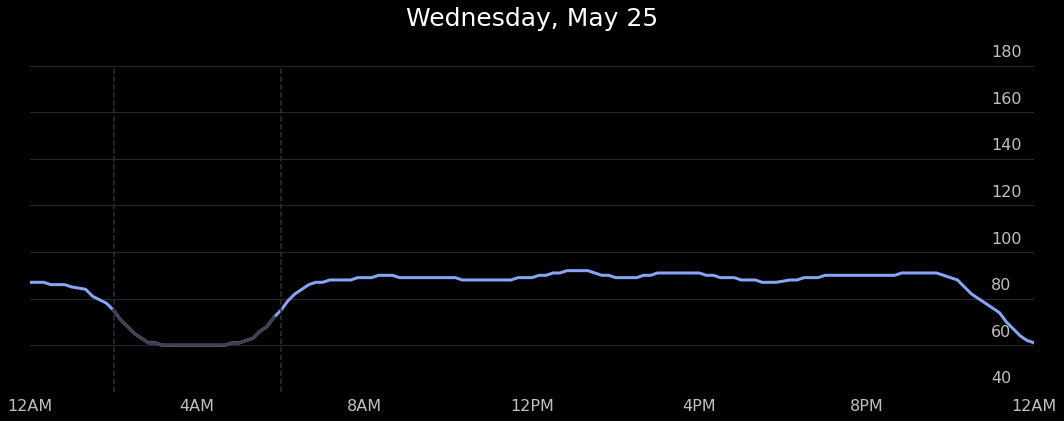

In [ ]:
#@title Enter date
date = "2022-05-25" #@param {type:"date"}
from matplotlib.ticker import FormatStrFormatter
import matplotlib.dates as dates
import matplotlib.transforms

from dateutil import tz
from scipy.interpolate import make_interp_spline
from datetime import timedelta

# measurements are taken every 10 minutes, displayed on app every 30
HEART_RATE_RECORDING_LENGTH = 30 * 60

with plt.style.context('dark_background'):
    # get the start and end times as timestamps by using the datetime library
    start_ts = datetime.strptime(date + ' 00:00:00-07:00', '%Y-%m-%d %H:%M:%S%z').timestamp()
    #end_ts = datetime.strptime(date + ' 23:59:59-07:00', '%Y-%m-%d %H:%M:%S%z').timestamp()
    end_ts = start_ts + 24 * 3600 + 30 * 60  # 00:30 the next day
    #end_ts = datetime.strptime('2022-05-25 00:30:00-07:00', '%Y-%m-%d %H:%M:%S%z').timestamp()

    # now find the indices in hr_df.timestamp that match as closely as possible
    start_idx = np.argmin(np.abs(hr_df.datetime.apply(lambda x: x.timestamp()) - start_ts))
    end_idx = np.argmin(np.abs(hr_df.datetime.apply(lambda x: x.timestamp()) - end_ts))

    x = hr_df.datetime.iloc[start_idx:end_idx]
    y = hr_df.heart_rate.iloc[start_idx:end_idx]

    # make it not as bumpy with gaussian filter. note that this does not reproduce
    # the curve exactly, as I'm not sure what smoothing algorithm they used...
    y = gaussian_filter(y, sigma=3)

    fig = plt.figure(figsize=(18,6), facecolor='black')

    x_timestamp = np.array([x_.timestamp() for x_ in x])

    # get the gaps. we include [6] as well because when you do np.diff,
    # it actually leaves out exactly one element
    differences = np.concatenate((np.diff(x_timestamp), [60 * 10]))

    # interpret a gap (i.e. when a user takes off the device for some prolonged
    # period of time) as any two measurements that are taken more than
    # 6 * 2 = 12 seconds apart, to account for minor variations around 6s
    gap_idxes = np.where(differences > HEART_RATE_RECORDING_LENGTH * 2)[0]

    # get the sleeps
    sleep_idxes = []
    for lower, upper in zip(sleeps_df.startdate, sleeps_df.enddate):
        if lower < start_ts or upper > end_ts:
            continue
        # get the location in the timestamp array that is closest to `lower`
        lower_idx = np.argmin(np.abs((x_timestamp - lower) - 0))
        # get the location in the timestamp array that is closest to `upper`
        upper_idx = np.argmin(np.abs((x_timestamp - upper) - 0))

        sleep_idxes.append((lower_idx, upper_idx))

    # first, we just plot the entire thing
    plt.plot(x, y, linewidth=3, color='#85a6f7')

    # now we overlay sleeps
    for sleep_start, sleep_end in sleep_idxes:
        plt.plot(x[sleep_start:sleep_end], y[sleep_start:sleep_end], linewidth=3, color='#3E414C')

        plt.axvline(x=x.iloc[sleep_start], linestyle='--', linewidth=1.5, color='#2F303A')

        plt.axvline(x=x.iloc[sleep_end], linestyle='--', linewidth=1.5, color='#2F303A')

    # now we overlay gaps by overlaying with white
    for gap_idx in gap_idxes:
        plt.plot(x[gap_idx:gap_idx+2], y[gap_idx:gap_idx+2], linewidth=5, color='black')

    plt.ylim(40, 180)
    plt.xlim(x.iloc[0], x.iloc[-1] - pd.Timedelta(minutes=30))

    datetimes = [
        datetime.strptime(date + ' 00:00:00-0700', '%Y-%m-%d %H:%M:%S%z'),
        datetime.strptime(date + ' 04:00:00-0700', '%Y-%m-%d %H:%M:%S%z'),
        datetime.strptime(date + ' 08:00:00-0700', '%Y-%m-%d %H:%M:%S%z'),
        datetime.strptime(date + ' 12:00:00-0700', '%Y-%m-%d %H:%M:%S%z'),
        datetime.strptime(date + ' 16:00:00-0700', '%Y-%m-%d %H:%M:%S%z'),
        datetime.strptime(date + ' 20:00:00-0700', '%Y-%m-%d %H:%M:%S%z'),
        datetime.strptime(date + ' 00:00:00-0700', '%Y-%m-%d %H:%M:%S%z') + timedelta(days=1)
    ]

    plt.xticks(ticks=datetimes, labels=['12AM', '4AM', '8AM', '12PM', '4PM', '8PM', '12AM'])

    # get the y-axis ticks to appear on the right
    plt.gca().yaxis.tick_right()

    #plt.gca().grid(axis='x', color='#2F303A')
    plt.gca().grid(axis='y', color='#2F303A', which='major')

    # hide x-axis and make the xtick labels 16 size
    plt.tick_params(
        axis='x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        labelsize=16,
        labelcolor='silver'
    )

    # hide y-axis and make the ytick labels 16 size
    plt.tick_params(
        axis='y',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        right=False,      # ticks along the bottom edge are off
        labelsize=16,
        labelcolor='silver'
    )

    # add offset to y-axis tick labels to make them appear above gridlines
    # instead of to the side
    # https://stackoverflow.com/questions/28615887/how-to-move-a-tick-label-in-matplotlib
    dx = -50/72.; dy = 15/72. 
    offset = matplotlib.transforms.ScaledTranslation(dx, dy, fig.dpi_scale_trans)
    for label in plt.gca().yaxis.get_majorticklabels():
        label.set_transform(label.get_transform() + offset)


    title_text = datetime.strftime(datetime.strptime(date, '%Y-%m-%d'), '%A, %B %d')

    plt.title(title_text, fontsize=25, pad=40)

    # turn off all borders
    plt.gca().spines['left'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['bottom'].set_visible(False)

*Above is a plot we created ourselves!*

Cool! Feel free to switch up the dates in the form as well, and see the user's heart rate for any day data has been collected for!

## 4.2: Sleeps over the course of a week

Now let's try to reproduce the plot below, which shows when and how long the user sleeps every day of the week. This is super cool because we can look at the user's sleeping patterns for an entire week at a glance, instead of having to sift through rows in a dataframe! We can do this by poking deeper into the [Matplotlib architecture](https://www.aosabook.org/en/matplotlib.html) into the Artist layer and directly adding rounded rectangles to the plot.

<img src="https://imgur.com/tV3K4wB.png"></img>

*The above plot is taken directly from the mobile app.*

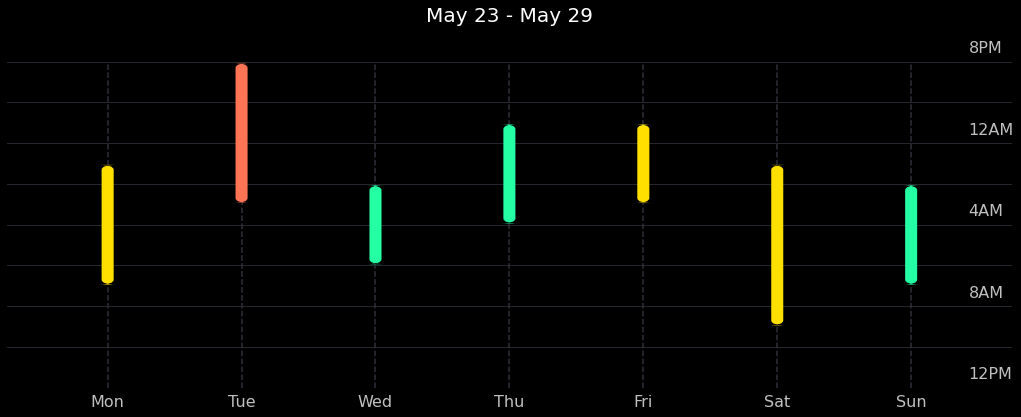

In [ ]:
#@title Insert start of week (must be a Monday) and timezone name

week_start = "2022-05-23" #@param {type:"date"}
timezone_name = "America/Los_Angeles" #@param {type:"string"}

from matplotlib.ticker import FormatStrFormatter
import matplotlib.dates as dates
import matplotlib.transforms
import matplotlib.patches as patches
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

from dateutil import tz
from scipy.interpolate import make_interp_spline

from datetime import timezone
import pytz

def timestamp_to_hour_min(timestamp, tz_name='America/Los_Angeles'):
    # convert timezone to '%H:%M' in local timezone

    local_tz = pytz.timezone(tz_name)
    return datetime.fromtimestamp(int(timestamp)).replace(tzinfo=timezone.utc).astimezone(local_tz).strftime('%H:%M')

def hour_min_to_vert_pos(hour_min):
    num_mins = (int(hour_min.split(':')[0]) * 60 + int(hour_min.split(':')[1]))
    vert_dist = (16 * 60 - num_mins) / (16 * 60)

    return vert_dist

# measurements are taken every 10 minutes, displayed on app every 30
HEART_RATE_RECORDING_LENGTH = 30 * 60

NUM_DAYS = 7
RECT_WIDTH = 0.02
RECTS_START = 0.1
RECTS_END = 0.9

# add on timezone
timezone_offset = datetime.now(pytz.timezone(timezone_name)).strftime('%z')
week_start = week_start + timezone_offset
week_start_ts = datetime.strptime(week_start, '%Y-%m-%d%z').timestamp()

with plt.style.context('dark_background'):
    fig, ax = plt.subplots(figsize=(18,6), facecolor='black')

    for day_num in range(NUM_DAYS):
        rect_center_pos = RECTS_START + day_num / (NUM_DAYS-1) * (RECTS_END - RECTS_START)
        # zorder to ensure it is drawn behind rect
        plt.axvline(x=rect_center_pos, linestyle='--', linewidth=1.5, color='#2F303A', zorder=0)

        # rounded rectangles
        # https://stackoverflow.com/questions/58425392/bar-chart-with-rounded-corners-in-matplotlib

        # subtract 4 hours because we want to capture sleeps that start from 8pm
        # and onward
        day_ts = week_start_ts + day_num * 24 * 3600 - 4 * 3600

        row = sleeps_df[np.logical_and(sleeps_df.startdate >= day_ts, sleeps_df.enddate <= day_ts + 24 * 3600)]

        # get the one with the longest sleep, this is how withings does it
        # source: https://support.withings.com/hc/en-us/community/posts/360026177173-Naps-don-t-count-for-sleep-tracking
        try:
            row = row.iloc[np.argmax(row.enddate - row.startdate)]
        except ValueError:
            continue

        # do a shift by 4 hours to account for difference b/w
        # 8PM and 12AM, a bit of a hack
        row.startdate += 4 * 3600
        row.enddate += 4 * 3600

        start, end = timestamp_to_hour_min(row.startdate, tz_name=timezone_name), timestamp_to_hour_min(row.enddate, tz_name=timezone_name)

        top_pos, bottom_pos = hour_min_to_vert_pos(start), hour_min_to_vert_pos(end)

        if row.data['sleep_score'] < 50:
            color = '#ff7455'
        elif row.data['sleep_score'] < 75:
            color = '#FEDF00'
        else:
            color = '#24ffa4'

        rect = patches.FancyBboxPatch((rect_center_pos - RECT_WIDTH / 2, bottom_pos),
                                      RECT_WIDTH, top_pos - bottom_pos,
                                      boxstyle="round,pad=-0.0040,rounding_size=0.015",
                                      linewidth=3, fc=color, ec='none')

        ax.add_patch(rect)

    plt.xticks(ticks=np.linspace(0.1,0.9,NUM_DAYS), labels=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
    plt.yticks(ticks=np.linspace(0, 1, 5), labels=['12PM', '8AM', '4AM', '12AM', '8PM'])

    # get the y-axis ticks to appear on the right
    plt.gca().yaxis.tick_right()

    plt.gca().yaxis.set_minor_locator(AutoMinorLocator(n=2))
    plt.gca().grid(axis='y', color='#2F303A', which='both')

    # hide x-axis and make the xtick labels 16 size
    plt.tick_params(
        axis='x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        labelsize=16,
        labelcolor='silver'
    )

    # hide y-axis and make the ytick labels 16 size
    plt.tick_params(
        axis='y',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        right=False,      # ticks along the bottom edge are off
        labelsize=16,
        labelcolor='silver'
    )

    # add offset to y-axis tick labels to make them appear above gridlines
    # instead of to the side
    # https://stackoverflow.com/questions/28615887/how-to-move-a-tick-label-in-matplotlib
    dx = -50/72.; dy = 15/72. 
    offset = matplotlib.transforms.ScaledTranslation(dx, dy, fig.dpi_scale_trans)
    for label in plt.gca().yaxis.get_majorticklabels():
        label.set_transform(label.get_transform() + offset)

    start_day_fmted = datetime.strftime(datetime.strptime(week_start, '%Y-%m-%d%z'), '%b %d')
    end_day_fmted = datetime.strftime(datetime.strptime(week_start, '%Y-%m-%d%z') + timedelta(days=6), '%b %d')
    plt.title(f'{start_day_fmted} - {end_day_fmted}', size=20, pad=40)

    plt.gca().set_axisbelow(True)
    # turn off all borders
    plt.gca().spines['left'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['bottom'].set_visible(False)

*Above is a plot we created ourselves!*

Looks like we were able to pretty accurately reproduce the same things you can see in the mobile app by querying the public API!

## 4.3: Watch wear time

Now what if we want to check when the user has worn the watch? For example, which days of the month has the user worn the watch, and of the days the user did not wear the watch all day, how much?

Fortunately, this idea is easy to execute with the use of [`july`](https://github.com/e-hulten/july/), a custom library that allows us to create beautiful calendar plots. Unfortunately, since the watch only samples the heart rate extremely sparsely (roughly every 10 minutes by default to preserve battery life), then it is hard to tell exactly when the watch is on or off. As a reasonable proxy of heart rate coverage throughout a particular day, we opt to count the number of hours in that day that the watch has logged at least 3 heart rate measurements for.

Note that we considered using the absolute number of heart rate measurements in a particular day as a proxy, but this is skewed by exercise periods, where the watch records heart rate at a much much higher sampling rate.

In [ ]:
#@title Specify start and end dates and extract watch usage metrics
start_date = "2022-01-01" #@param {type:"date"}
end_date = "2022-06-01" #@param {type:"date"}

dates = date_range(start_date, end_date)
data = np.zeros((len(dates), 24))

# populate data array
for idx, date in tqdm(list(enumerate(dates))):
    local_tz = pytz.timezone('America/Los_Angeles')

    day_start = pd.Timestamp(date).replace(tzinfo=local_tz)

    for i in range(24):
        hour_start, hour_end = day_start + pd.Timedelta(hours=i), day_start + pd.Timedelta(hours=i+1)

        # check for number of measurements during this time
        bool_arr = np.logical_and(datetime.fromtimestamp(int(hour_start.timestamp())) < hr_df.datetime,
               hr_df.datetime < datetime.fromtimestamp(int(hour_end.timestamp())))

        num_measurements = len(np.where(bool_arr)[0])

        if num_measurements >= 3:
            data[idx, i] = 1

# A couple TODO's for modifying july to make it fit our usage better
# TODO 1: apply patch to this line https://github.com/e-hulten/july/blob/953ef3ee20549ca791d88d2f08e54862aa4c2f58/src/july/helpers.py#L118
# to make the fontsize for text values smaller
# TODO 2: apply patch to this line https://github.com/e-hulten/july/blob/master/src/july/plot.py#L149
# to make the weeknum_labels refer to the month day number instead

  0%|          | 0/152 [00:00<?, ?it/s]

Now we make the calendar plot! The above cell calculated `data`. `data` is a 2D numpy array with axes (day, hour), where the first axis refers to a particular day and the second axis refers to a particular hour of the day. The value for, say `data[130,8]`, is exactly one if the user wore his watch from 8am to 9am on day 130 (which is 130 days after `start_date` as specified above) and otherwise zero.

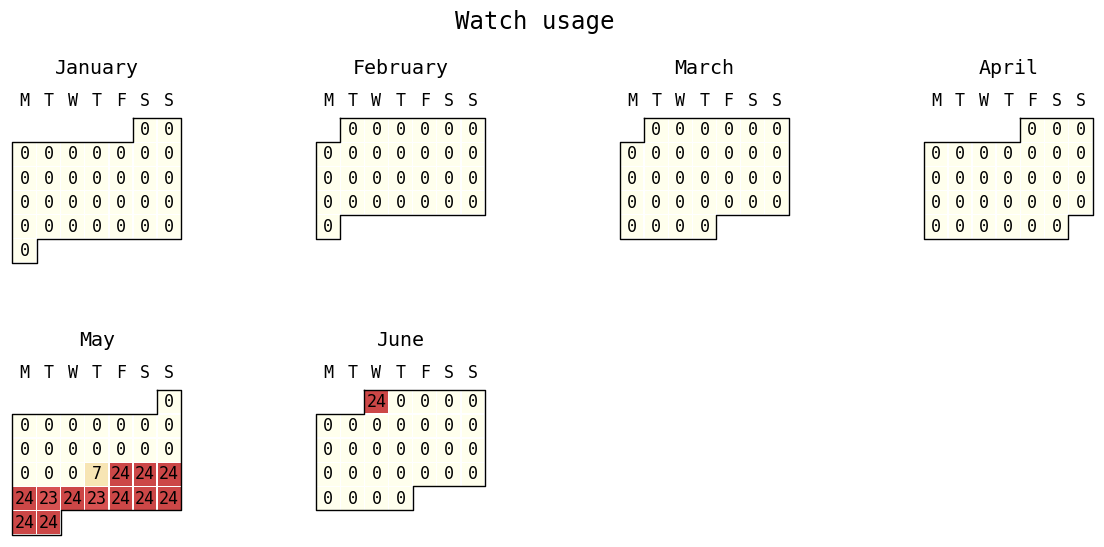

In [ ]:
# sum across hour axis
july.calendar_plot(dates, data.sum(axis=1), value_label=True, weeknum_label=False, title=False)
plt.suptitle('Watch usage', fontsize="x-large", y=1.03)
plt.show()  # suppress output from above line

As we can see, our user has been fairly consistent about wearing his watch. He's worn his watch for nearly every hour of the day every day.

If we want to check *when* the user has failed to wear his watch, we can simply look at the `data` array we populated. First, we get the start and end indices for watch measurements.

In [ ]:
start_idx = np.where(data.sum(axis=1) > 0)[0][0]
end_idx = np.where(data.sum(axis=1) > 0)[0][-1]

print(f'Data collection started at index {start_idx}')
print(f'Data collection last performed at index {end_idx}')

Data collection started at index 138
Data collection last performed at index 151


Then, we exclude the first and last indices (because they have gone for half a day, so may skew the data) and look at which hours the user tends to miss for an average day of full usage.

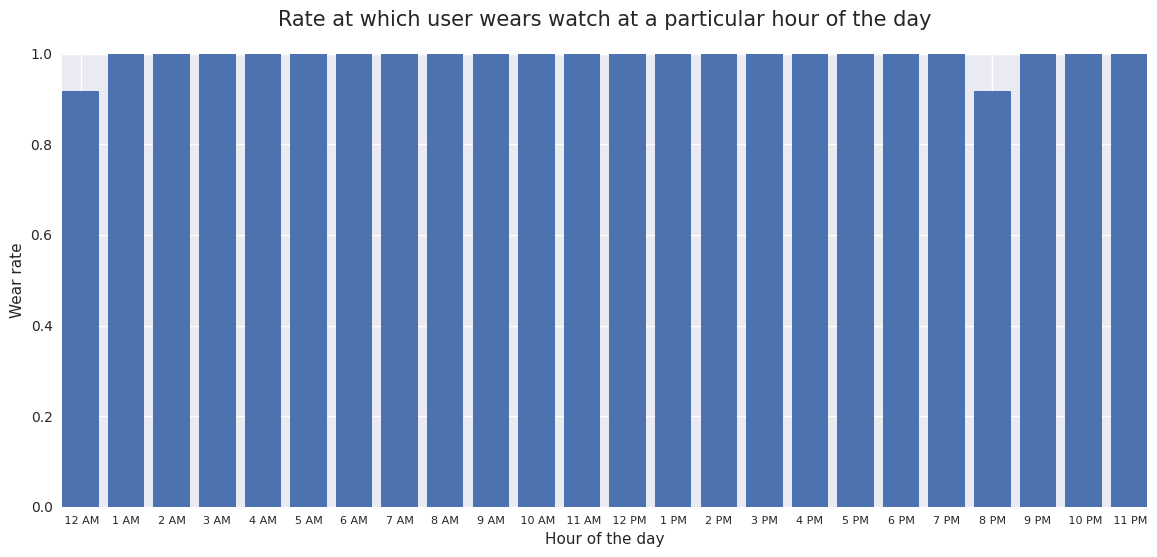

In [ ]:
def stylize_hour_num(hour):
    return datetime.strftime(datetime.strptime(str(hour), '%H'), ' %I %p').replace(' 0','')

with plt.style.context('seaborn'):
    plt.figure(figsize=(14,6))
    plt.bar(np.arange(24), data[start_idx+1:end_idx].mean(axis=0))

    plt.title('Rate at which user wears watch at a particular hour of the day',
              pad=20, fontsize=15)

    plt.xticks(ticks=np.arange(24), labels=[stylize_hour_num(i) for i in range(24)], fontsize=8)

    plt.ylabel('Wear rate')
    plt.xlabel('Hour of the day')

As we can see, though the user sometimes takes his watch off, he still wears it 80% of the time in the worst case.

# 5. Data Analysis

Data isn't much without some analysis, so we're going to do some in this section.

DISCLAIMER: the analyses below may not be 100% biologically or scientifically grounded; the code is here to assist in your process, if you are interested in asking these kinds of questions.

## 5.1: Heart rate vs. sleep period length

Maybe the heart rate is correlated with how long a particular sleep period was. Let's see if this hypothesis is true.

In [ ]:
#@title Set date range and timezone
start = "2020-01-01" #@param {type:"date"}
end = "2022-05-22" #@param {type:"date"}
timezone = "US/Pacific" #@param {type:"string"}
params_all = {
    'start': f'{start}T00:00:00.000Z',
    'end': f'{end}T00:00:00.000Z'
}

First we get the length of each sleep in hours.

In [ ]:
sleeps_df['Length (hours)'] = (sleeps_df.enddate - sleeps_df.startdate) / 3600

Next we get the median heart rate for each sleep.

In [ ]:
measurement_timestamps = hr_df.datetime.apply(lambda x: x.timestamp())

all_heart_rates = []
median_heart_rates = []

for sleep_start, sleep_end in zip(sleeps_df.startdate, sleeps_df.enddate):
    idxes = np.where(np.logical_and(measurement_timestamps > sleep_start, measurement_timestamps < sleep_end))[0]

    heart_rates = np.array(hr_df.iloc[idxes].heart_rate)

    all_heart_rates.append(heart_rates)
    median_heart_rates.append(np.median(heart_rates))

sleeps_df['Median heart rate'] = median_heart_rates

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Let's make a quick plot to get some intuition. Here we just use [seaborn](https://seaborn.pydata.org/), as it's very quick to get beautiful plots out with minimal effort.

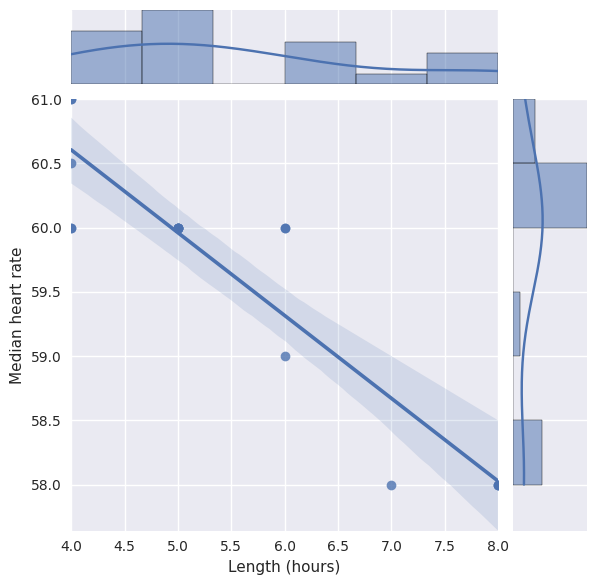

In [ ]:
with plt.style.context('seaborn'):
    p = sns.jointplot(x='Length (hours)', y='Median heart rate', data=sleeps_df, kind='reg')

As we can see from the scatterplot above, it looks like there might be a correlation there. Let's compute $R^2$ just to see exactly how correlated.

We'll follow [this documentation](https://docs.scipy.org/doc/scipy-0.15.1/reference/generated/scipy.stats.linregress.html) and perform a linear regression to obtain the coefficient of determination.

In [ ]:
from scipy import stats

# eliminate any nan's
filtered_sleeps = sleeps_df[~np.isnan(sleeps_df['Median heart rate'])]

slope, intercept, r_value, p_value, std_err = stats.linregress(filtered_sleeps['Length (hours)'],
                                                               filtered_sleeps['Median heart rate'])

print(f'Slope: {slope:.3g}')
print(f'Coefficient of determination: {r_value**2:.3g}')
print(f'p-value: {p_value:.3g}')

Slope: -0.645
Coefficient of determination: 0.849
p-value: 5.72e-08


We also see that the p-value, which is determined by scipy to be the two-sided p-value for a hypothesis test whose null hypothesis is that the slope is zero, is significant ($<$0.05).

So given this evidence from this particular data, maybe length of a sleep period is correlated with your heart rate.

## 5.2: Outlier Detection

However, let us suppose that there is an outlier here. We'll manually inject one, as one is currently not really present in the data, just to demo that we can deal with outliers here.

In [ ]:
import copy
outlier = copy.deepcopy(sleeps_df.iloc[0])
outlier['Length (hours)'] = 8
outlier['Median heart rate'] = 120

filtered_sleeps = filtered_sleeps.append(outlier, ignore_index=True)

Now that we know that there is at least one outlier in this dataset, let's implement a system based on a normal distribution to automatically detect and remove outliers like this, based on the method described [here](https://medium.com/analytics-vidhya/outlier-detection-with-multivariate-normal-distribution-in-python-480033ba3a8a).

[  8. 120.]  is an outlier
18


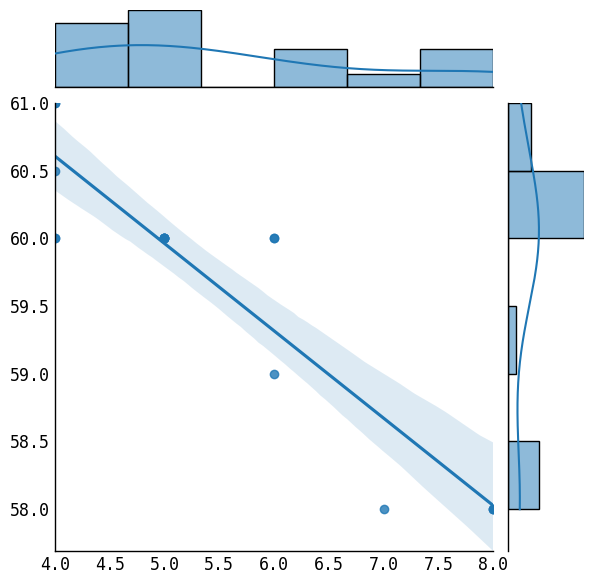

In [ ]:
from scipy.stats import multivariate_normal

# calculate the covariance matrix
data = np.stack((filtered_sleeps['Length (hours)'], filtered_sleeps['Median heart rate']), axis=0)
covariance_matrix = np.cov(data)

# calculating the mean
mean_values = [np.mean(filtered_sleeps['Length (hours)']),np.mean(filtered_sleeps['Median heart rate'])]

# multivariate normal distribution
model = multivariate_normal(cov=covariance_matrix,mean=mean_values)
data = np.stack((filtered_sleeps['Length (hours)'], filtered_sleeps['Median heart rate']),axis=1)

# finding the outliers
# any point with a probability lower than the threshold value is considered an outlier and removed 
threshold = 1.0e-05
outlier = model.pdf(data).reshape(-1) < threshold

new_data = copy.deepcopy(data)

for i, boolean in enumerate(outlier):
  if boolean:
    print(data[i], " is an outlier")
    print(np.where(np.logical_and(data[:,0] == data[i,0], data[:,1] == data[i,1]))[0].item(0))
    # delete outliers
    new_data = np.delete(new_data, np.where(np.logical_and(data[:,0] == data[i,0], data[:,1] == data[i,1]))[0].item(0),axis=0)

# plot new graph with outliers removed
# new_data[:,0] correspond to the new lengths, and new_data[:,1] correspond to the new values
p = sns.jointplot(x=new_data[:,0], y=new_data[:,1], kind='reg')

As we can see, our outlier detection system found the outlier and excluded it from our dataset, as needed.